In [ ]:
# !pip install datasets
!pip install tensorflow==2.14.1
!pip install keras==2.14.0
!pip install wurlitzer==3.1.1
!pip install ml-dtypes==0.2.0
!pip install pydantic==1.10.11

In [ ]:
import os
import numpy as np
import h5py
import cv2
import tifffile
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

import keras
import tensorflow

In [ ]:
output_image_dir = "/kaggle/working/train/images"
output_label_dir = "/kaggle/working/train/labels"
if not os.path.exists(output_image_dir):
    os.mkdir(output_image_dir)
if not os.path.exists(output_label_dir):
    os.mkdir(output_label_dir)
    
output_image_dir = "/kaggle/working/test/images"
output_label_dir = "/kaggle/working/test/labels"
if not os.path.exists(output_image_dir):
    os.mkdir(output_image_dir)
if not os.path.exists(output_label_dir):
    os.mkdir(output_label_dir)
    
output_image_dir = "/kaggle/working/val/images"
output_label_dir = "/kaggle/working/val/labels"
if not os.path.exists(output_image_dir):
    os.mkdir(output_image_dir)
if not os.path.exists(output_label_dir):
    os.mkdir(output_label_dir)

In [ ]:
output_train_image_dir = "/kaggle/working/train/images"
output_train_label_dir = "/kaggle/working/train/labels"

output_test_image_dir = "/kaggle/working/test/images"
output_test_label_dir = "/kaggle/working/test/labels"

output_val_image_dir = "/kaggle/working/val/images"
output_val_label_dir = "/kaggle/working/val/labels"

CROP_SIZE = 256

In [ ]:
def list_files(folder, extension='.tiff'):
    filenames = os.listdir(folder)
    filepaths = [os.path.join(folder, filename) for filename in filenames]
    return filepaths

def load_image(file_path):
    tiff_data = tifffile.imread(file_path)
    np_array = np.array(tiff_data)
    return np_array

def binarize(image):
    _, binary = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)
    return binary

def create_crops(image, label, size=256):
    crops = []
    labels = []
    h, w, _ = image.shape
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            crop_img = image[i:i+size, j:j+size]
            crop_label = label[i:i+size, j:j+size]
            if np.mean(crop_label) > 0.01 and 0 < np.mean(crop_img) < 255:  # Checking if label is not 99% black
                crops.append(crop_img)
                labels.append(crop_label)
    return crops, labels

In [ ]:
def crop_and_map_labels(output_image_dir,output_label_dir, input_dir):
    
        count = 0
        image_folder = f'{input_dir}/'
        label_folder = f'{input_dir}_labels/'

        label_paths = list_files(label_folder)
        print(label_paths[0:5])

        for lbl_path in label_paths:
            image_path = os.path.join(image_folder, os.path.basename(lbl_path) + 'f')
            if not os.path.exists(image_path):
                print(f"{image_path} doesn't exist")
                continue
            image = load_image(os.path.join(image_folder, os.path.basename(lbl_path)+'f'))
            label = load_image(lbl_path)

            crops, labels = create_crops(image, label, CROP_SIZE)

            for idx, (crop_img, crop_label) in enumerate(zip(crops, labels)):
                crop_img = crop_img
                crop_label = binarize(crop_label)

                cv2.imwrite(os.path.join(output_image_dir, f"crop_{count}.png"), crop_img)
                cv2.imwrite(os.path.join(output_label_dir, f"crop_{count}.png"), crop_label)
                count = count+1
                
folders = [
        '/kaggle/input/massachusetts-roads-dataset/tiff/train',
        '/kaggle/input/massachusetts-roads-dataset/tiff/test',
        '/kaggle/input/massachusetts-roads-dataset/tiff/val'
]
    
crop_and_map_labels(output_train_image_dir, output_train_label_dir, folders[0])
crop_and_map_labels(output_test_image_dir, output_test_label_dir, folders[1])
crop_and_map_labels(output_val_image_dir, output_val_label_dir, folders[2])

In [ ]:
def display_example_images(output_image_dir, output_label_dir):
    """
    Display an example image from the output_image_dir and output_label_dir.
    """
    example_image_path = os.path.join(output_image_dir, "crop_1.png")
    example_label_path = os.path.join(output_label_dir, "crop_1.png")

    if os.path.exists(example_image_path) and os.path.exists(example_label_path):
        image = cv2.imread(example_image_path)
        label = cv2.imread(example_label_path, cv2.IMREAD_GRAYSCALE)

        # Convert BGR (OpenCV format) to RGB for matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Example Image")
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Example Label")
        plt.imshow(label, cmap='gray')
        plt.axis('off')

        plt.show()
    else:
        print("Example images not found. Ensure at least one crop has been created.")
        
display_example_images(output_test_image_dir, output_test_label_dir)
display_example_images(output_train_image_dir, output_train_label_dir)
display_example_images(output_val_image_dir, output_val_label_dir)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# paths = {"train":["/kaggle/working/train/images", "/kaggle/working/train/labels"]}
    
seed=24
batch_size= 16

#If You need to resize images then add this to the flow_from_directory parameters 
#target_size=(150, 150), #Or whatever the size is for your network
def image_and_mask_generator(image_dir, label_dir):
    img_data_gen_args = dict(rescale = 1/255.)
    mask_data_gen_args = dict()

    image_data_generator = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_data_generator.flow_from_directory(image_dir, 
                                                               seed=seed, 
                                                               batch_size=batch_size,
                                                               classes = ["."],
                                                               class_mode=None #Very important to set this otherwise it returns multiple numpy arrays thinking class mode is binary.
                                                               )  

    mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
    mask_generator = mask_data_generator.flow_from_directory(label_dir, 
                                                            classes = ["."],
                                                            seed=seed, 
                                                            batch_size=batch_size,
                                                            color_mode = 'grayscale', #Read masks in grayscale
                                                             class_mode=None
                                                             )
    print(image_generator.filenames[0:5])
    print(mask_generator.filenames[0:5])
    
    generator = zip(image_generator, mask_generator)
    return generator

train_generator = image_and_mask_generator(output_train_image_dir,output_train_label_dir)
test_generator = image_and_mask_generator(output_test_image_dir,output_test_label_dir)
val_generator = image_and_mask_generator(output_val_image_dir,output_val_label_dir)

In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs, outputs, name="U-NET")
    return model

In [ ]:
IMAGE_HEIGHT = IMAGE_WIDTH = CROP_SIZE #256

In [ ]:
u_net_model = unet(input_size=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

In [ ]:
u_net_model.summary()
# tensorflow.keras.utils.plot_model(u_net_model, show_shapes=True)

In [ ]:
def iou_coef(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    union = tensorflow.reduce_sum(y_true) + tensorflow.reduce_sum(y_pred) - intersection
    
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    total = tensorflow.reduce_sum(y_true) + tensorflow.reduce_sum(y_pred)
    
    return (2. * intersection + smooth) / (total + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
EPOCHS = 2 # 5 epochs default 2 epochs for testing
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [ ]:
model_path = "/kaggle/working/spectrewolf8/local/aerial-image-road-segmentation-xp/aerial-image-road-segmentation-xp.keras"

checkpointer = ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only = True, verbose=1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, epsilon=1e-4)

In [ ]:
opt = keras.optimizers.Adam(LEARNING_RATE)
u_net_model.compile(optimizer=opt, loss=soft_dice_loss, metrics=[iou_coef])

In [ ]:
def create_generator(zipped):
    for (img, mask) in zipped:
        yield (img, mask)

# gen = create_generator(train_generator)
# first_item,first_item_2 = next(gen)
# print(first_item,first_item_2)

In [ ]:
# Check for available GPUs
gpus = tensorflow.config.list_physical_devices('GPU')

if gpus:
    print(f"GPUs available: {len(gpus)}")
else:
    print("No GPUs found.")

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "0" for the first GPU, "1" for the second, etc.

# gpu_devices = tensorflow.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tensorflow.config.experimental.set_memory_growth(device, True)

In [ ]:
history = u_net_model.fit(
    create_generator(train_generator), 
    epochs=EPOCHS,
    steps_per_epoch = len(os.listdir(output_train_image_dir)) // BATCH_SIZE,
    batch_size = BATCH_SIZE,
    callbacks = [checkpointer, earlystopper, lr_reducer],
)

In [ ]:
print(history.model)

In [ ]:
model_path = "/kaggle/working/local/aerial-image-road-segmentation-xp.keras"
u_net_model.save(model_path, save_format='keras')

# Test

In [ ]:
!pip install huggingface_hub

In [ ]:
#load tokens
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login

# Define repository name and local path
repo_name = "spectrewolf8/aerial-image-road-segmentation-xp"
repo_path = "spectrewolf8/aerial-image-road-segmentation-xp"
model_path = "/kaggle/working/spectrewolf8/aerial-image-road-segmentation-xp/aerial-image-road-segmentation-xp.keras"

#logging into Hugging Face
!huggingface-cli login --token $hf_token

# Create a repository
api = HfApi()

api.create_repo(repo_id=repo_name, exist_ok=True)

# Initialize the local repository
repo = Repository(local_dir=repo_path, clone_from=repo_name)

# Copy the model file to the repository directory
import shutil
shutil.copy(model_path, repo_path)  # or .h5 file

# Push to the Hub
repo.push_to_hub()

In [ ]:
from huggingface_hub import hf_hub_download
import tensorflow as tf

# Define your model repository and file name
repo_name = "spectrewolf8/aerial-image-road-segmentation-xp"
filename = "aerial-image-road-segmentation-xp.keras"  # Update this to the actual model file name

# Define the directory where you want to save the downloaded model
download_dir = "/kaggle/working/spectrewolf8/cache/"

# Download the model file from Hugging Face Hub to the specified directory
local_model_path = hf_hub_download(repo_id=repo_name, filename=filename, cache_dir=download_dir)

# Load the model
model = tf.keras.models.load_model(local_model_path, custom_objects={'soft_dice_loss': soft_dice_loss, 'dice_coef': dice_coef, "iou_coef": iou_coef})

# Check the model summary
model.summary()

In [ ]:
def iou_coef(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    union = tensorflow.reduce_sum(y_true) + tensorflow.reduce_sum(y_pred) - intersection
    
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    total = tensorflow.reduce_sum(y_true) + tensorflow.reduce_sum(y_pred)
    
    return (2. * intersection + smooth) / (total + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
def load_test_images_and_masks(image_folder, mask_folder, size=256):
    image_paths = sorted([os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder) if fname.endswith('.png')])
    
    images = []
    masks = []
    
    for img_path, mask_path in zip(image_paths[0:10], mask_paths[0:10]):
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (size, size))
        mask = cv2.resize(mask, (size, size))
        mask = (mask > 127).astype(np.uint8)
        
        images.append(image)
        masks.append(mask)
        
    images = np.array(images) / 255.0
    masks = np.array(masks).reshape((-1, size, size, 1))
    
    return images, masks

test_image_folder = "/kaggle/working/images"
test_mask_folder = "/kaggle/working/labels"

test_images, test_masks = load_test_images_and_masks(test_image_folder, test_mask_folder)

In [39]:
from tensorflow.keras.models import load_model
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
# import keras.src.models.functional

model_path = "/kaggle/working/spectrewolf8/aerial-image-road-segmentation-xp/aerial-image-road-segmentation-xp.keras"
u_net_model = load_model(model_path, custom_objects={'soft_dice_loss': soft_dice_loss, 'dice_coef': dice_coef, "iou_coef": iou_coef})


# Evaluate the model
#  loss, iou = u_net_model.evaluate( create_generator(val_generator),)
loss, iou =u_net_model.evaluate( create_generator(val_generator), steps=10) 
# print(u_net_model.evaluate())
print(f"Test Loss: {loss}")
print(f"Test IOU: {iou}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - iou_coef: 0.6011 - loss: 0.2505
Test Loss: 0.23967090249061584
Test IOU: 0.6151987314224243


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


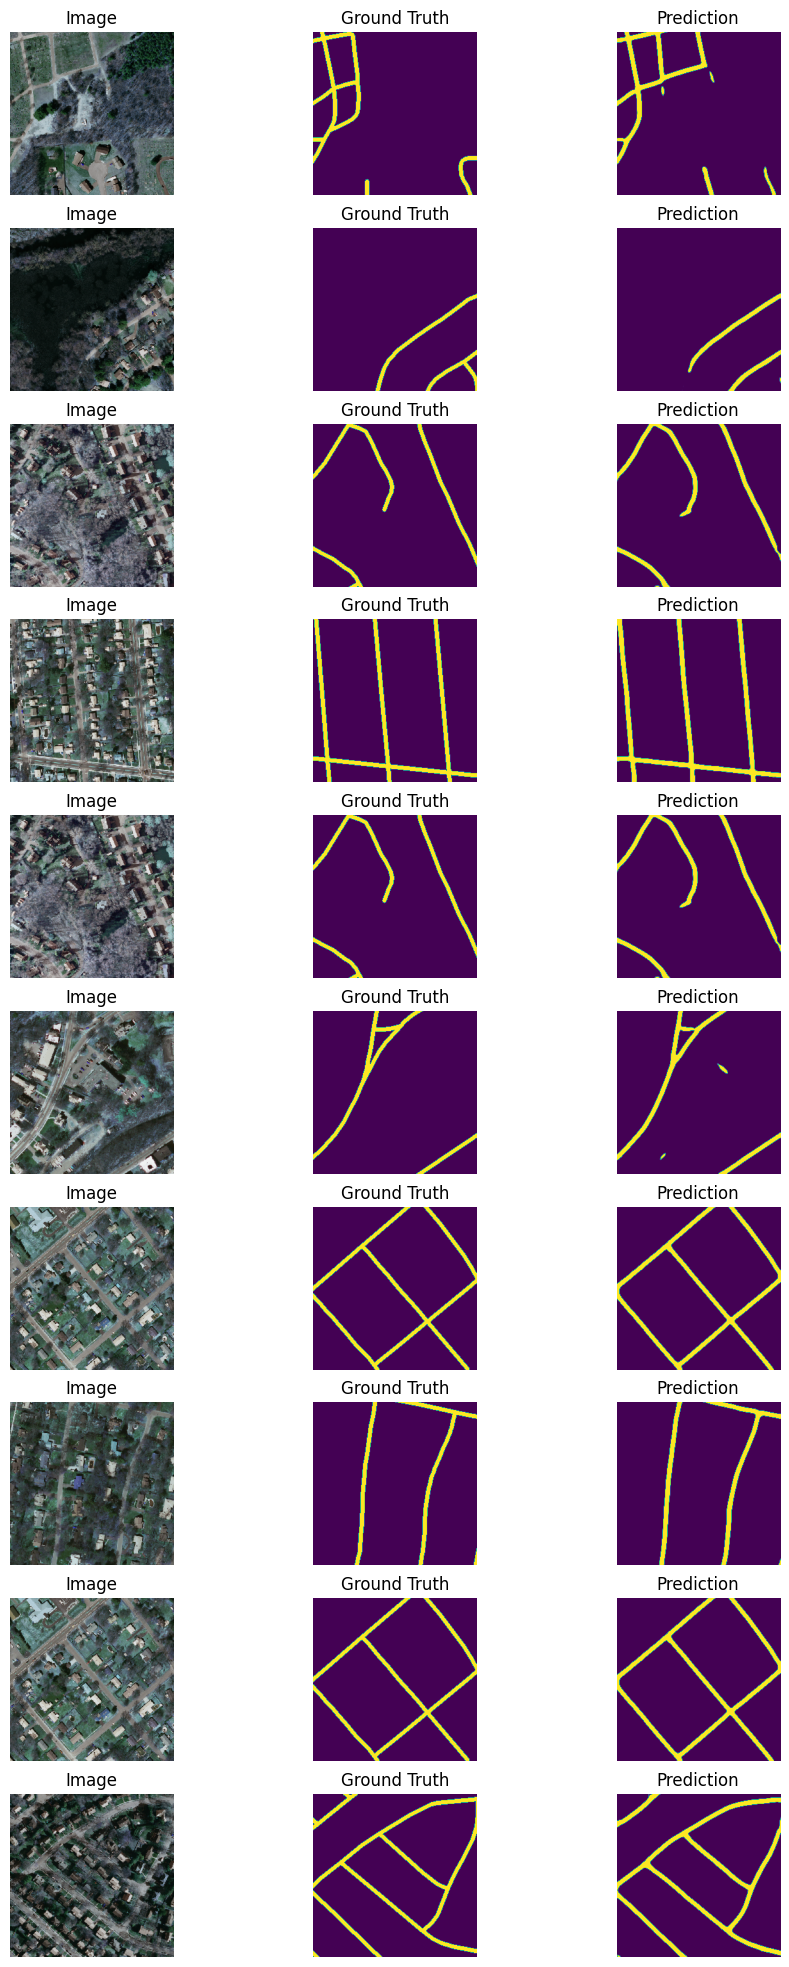

In [48]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Assuming create_generator is defined and provides images for prediction
images, ground_truth_masks = next(create_generator(test_generator))

# Make predictions
predictions = u_net_model.predict(images)

# Apply threshold to predictions
thresh_val = 0.1
prediction_threshold = (predictions > thresh_val).astype(np.uint8)

# Visualize results
num_samples = min(10, len(images))  # Use at most 10 samples or the total number of images available
f = plt.figure(figsize=(15, 25))
for i in range(num_samples):
    ix = random.randint(0, len(images) - 1)  # Ensure ix is within range

    f.add_subplot(num_samples, 4, i * 4 + 1)
    plt.imshow(images[ix])
    plt.title("Image")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i * 4 + 2)
    plt.imshow(np.squeeze(ground_truth_masks[ix]))
    plt.title("Ground Truth")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i * 4 + 3)
    plt.imshow(np.squeeze(predictions[ix]))
    plt.title("Prediction")
    plt.axis('off')

#     f.add_subplot(num_samples, 4, i * 4 + 4)
#     plt.imshow(np.squeeze(prediction_threshold[ix]))
#     plt.title(f"Thresholded at {thresh_val}")
#     plt.axis('off')

plt.show()


# TEST